In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *
import matplotlib.pyplot as plt 

from scipy.cluster.hierarchy import *
from scipy.stats.contingency import crosstab

from scipy.interpolate import interp2d, interp1d

from scipy.special import rel_entr

rng = np.random.default_rng()

import sklearn.decomposition

import ipyparallel as ipp

In [2]:
TMG = TissueMultiGraph('TMG_dev7.pkl')

In [154]:
Env = TMG.Layers[0].extract_environments(ordr=4)
row_sums = Env.sum(axis=1)
row_sums = row_sums[:,None]
Env = Env/row_sums

In [155]:
cluster = ipp.Cluster.from_file()
rc = cluster.connect_client_sync()
dview = rc[:]
dview.push({'Env': Env})
with dview.sync_imports():
    import numpy
    import sklearn.decomposition

importing numpy on engine(s)
importing sklearn.decomposition on engine(s)


In [156]:
@dview.parallel(block=True)
def lda_fit(n_topics):
    lda = sklearn.decomposition.LatentDirichletAllocation(n_components=n_topics)
    B = lda.fit_transform(Env)
    return(numpy.argmax(B,axis=1))
    
Ntopics = np.arange(2,120,2)    
result = lda_fit.map(Ntopics)

In [157]:
IDs = np.array(result).T
Cond_Entropy = np.zeros(Ntopics.shape)
UsedTopics = np.zeros(Ntopics.shape)
for i in range(len(Ntopics)):
    Cond_Entropy[i] = TMG.Layers[1].contract_graph(IDs[:,i]).cond_entropy()
    UsedTopics[i] = len(np.unique(IDs[:,i]))



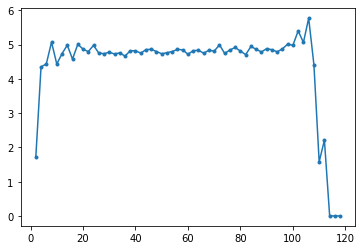

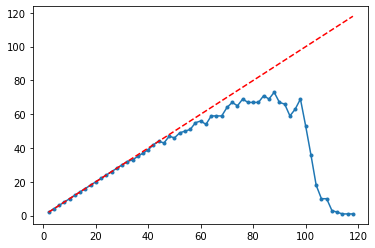

In [158]:
plt.plot(Ntopics,Cond_Entropy,'.-')
plt.figure()
plt.plot(Ntopics,UsedTopics,'.-')
plt.plot(Ntopics,Ntopics,'r--')

In [159]:
ID_entropy=np.zeros(IDs.shape[1])
Type_entropy = np.zeros(IDs.shape[1])
Zone_entropy = np.zeros(IDs.shape[1])
for i in range(IDs.shape[1]):
    ID_entropy[i] = entropy(IDs[:,i], base=2)
    _,cnt = np.unique(IDs[:,i],return_counts=True)
    cnt=cnt/cnt.sum()
    Type_entropy[i] = entropy(cnt,base=2) 
    CG=TMG.Layers[1].contract_graph(IDs[:,i])
    _,cnt = np.unique(CG.UpstreamMap,return_counts=True)
    cnt=cnt/cnt.sum()
    Zone_entropy[i] = entropy(cnt,base=2) 

/home/rwollman/miniconda3/envs/dredFISH/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


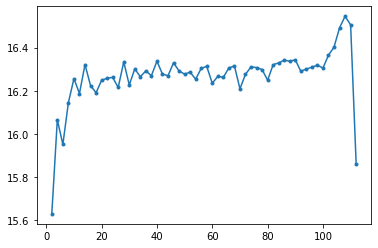

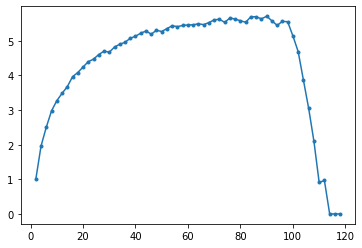

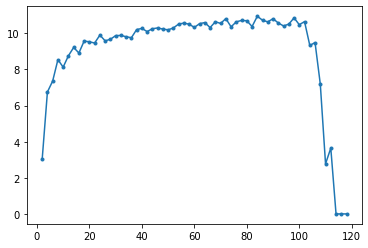

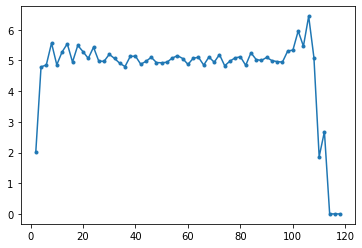

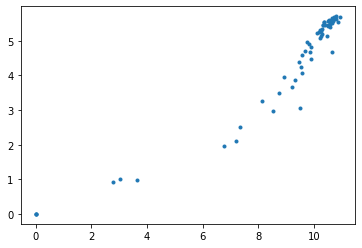

In [160]:
plt.plot(Ntopics,ID_entropy,'.-')
plt.figure()
plt.plot(Ntopics,Type_entropy,'.-')
plt.figure()
plt.plot(Ntopics,Zone_entropy,'.-')
plt.figure()
plt.plot(Ntopics,Zone_entropy-Type_entropy,'.-')
plt.figure()
plt.plot(Zone_entropy,Type_entropy,'.')

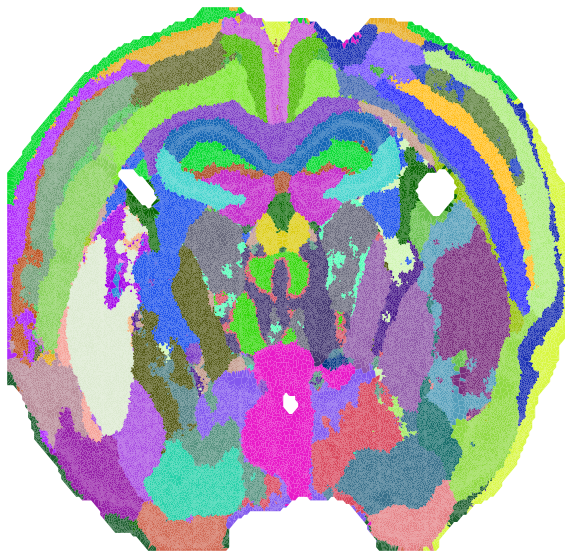

In [165]:
to_map = IDs[:,np.argmax(Type_entropy)]
V = RandomColorpleth(TMG,id_vec=to_map)
V.set_view()
V.figsize=(10,10)
V.plot()

In [164]:
CG = TMG.Layers[0].contract_graph(IDs[:,np.argmax(Type_entropy)])
print(f"N: {CG.N} Ntypes: {CG.Ntypes}")

N: 790 Ntypes: 67


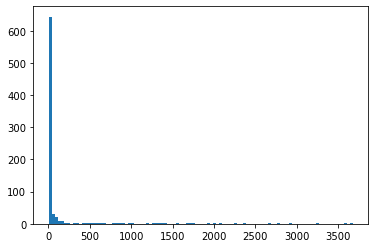

In [167]:
plt.hist(CG.node_size,bins=100);

In [169]:
sum(CG.node_size<10)

559

Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}
Controller stopped: {'exit_code': None, 'pid': 3361175, 'identifier': 'ipcontroller-3362077'}


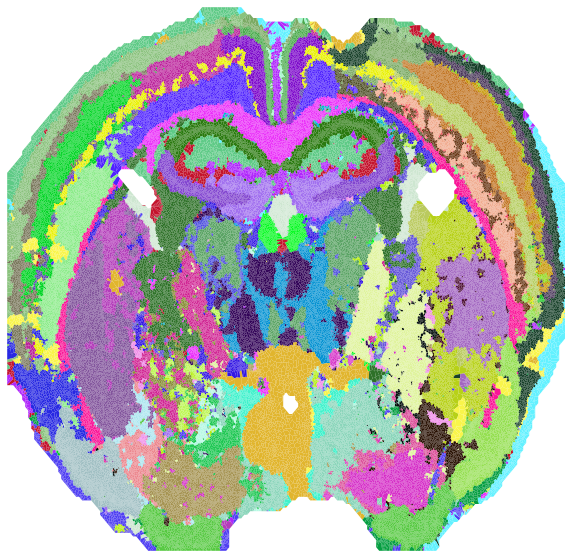

In [148]:
to_map = IDs[:,np.argmax(Type_entropy)]
V = RandomColorpleth(TMG,id_vec=to_map)
V.set_view()
V.figsize=(10,10)
V.plot()

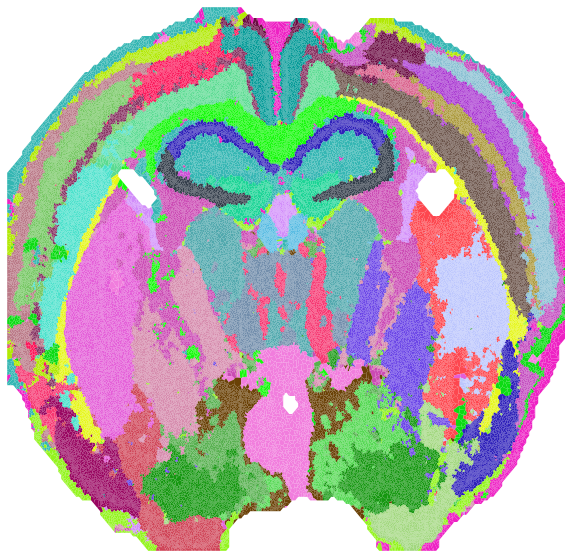

In [153]:
to_map = IDs[:,21]
V = RandomColorpleth(TMG,id_vec=to_map)
V.set_view()
V.figsize=(10,10)
V.plot()

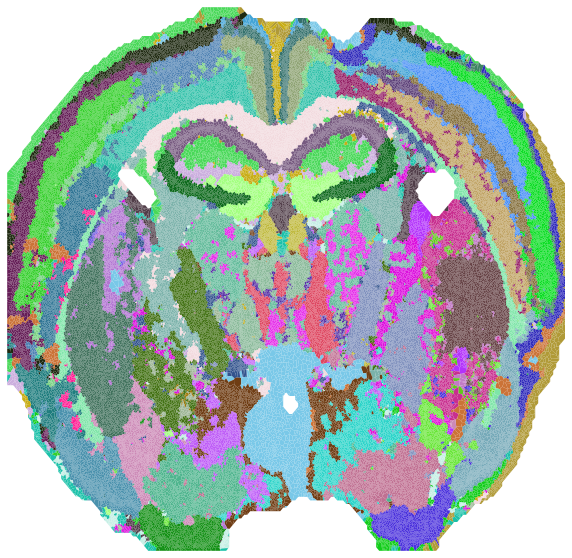

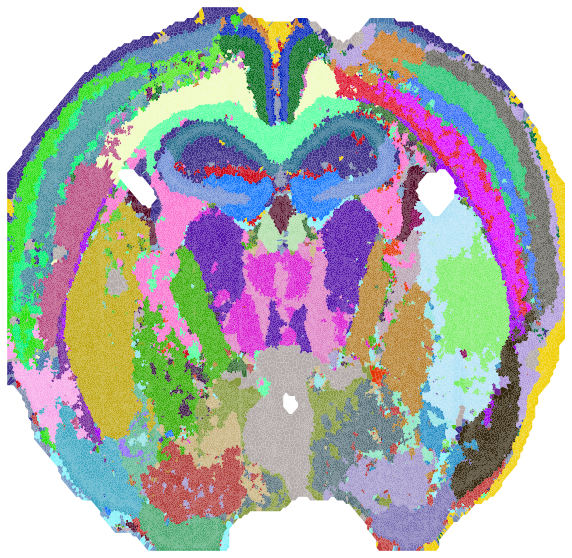

In [125]:
# to_map = IDs[:,np.argmax(Type_entropy)]
# V = RandomColorpleth(TMG,id_vec=to_map)
# V.set_view()
# V.figsize=(10,10)
# V.plot()

# to_map = IDs[:,30]
# V = RandomColorpleth(TMG,id_vec=to_map)
# V.set_view()
# V.figsize=(10,10)
# V.plot()

In [123]:
print(f"Type entropy, argmax: {np.argmax(Type_entropy)} Ntopics: {Ntopics[np.argmax(Type_entropy)]}")
print(f"Cond entropy, argmax: {np.argmax(Cond_Entropy)} Ntopics: {Ntopics[np.argmax(Cond_Entropy)]}")

Type entropy, argmax: 24 Ntopics: 74
Cond entropy, argmax: 36 Ntopics: 110


In [137]:
print(f"Type entropy, argmax: {np.argmax(Type_entropy)} Ntopics: {Ntopics[np.argmax(Type_entropy)]}")
print(f"Cond entropy, argmax: {np.argmax(Cond_Entropy)} Ntopics: {Ntopics[np.argmax(Cond_Entropy)]}")

Type entropy, argmax: 41 Ntopics: 84
Cond entropy, argmax: 54 Ntopics: 110


In [143]:
np.flatnonzero(Ntopics==60)

array([29])